<a href="https://colab.research.google.com/github/adeepH/OLD-Shared-Task/blob/main/Bert%2BbiLSTM_Tamil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers==3.3.1

     |████████████████████████████████| 1.1MB 23.6MB/s 
     |████████████████████████████████| 3.0MB 55.1MB/s 
     |████████████████████████████████| 890kB 47.2MB/s 
     |████████████████████████████████| 1.1MB 46.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=2eab3e5cc0c7aceb6a4b321d762ebe1a8ad81f390f7732181733ddc60676d074
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
train=pd.read_csv('/content/tamil_offensive_full_train.tsv', header=None, names=['tweets','label'], sep="\t")
train['labels']=LabelEncoder().fit_transform(train['label'])
train=train.drop(columns='label')
train

,tweets,labels
0,movie vara level la Erika poguthu,0
1,I love Ajith Kumar Vivegam movie inki mjy bht ...,5
2,Padam nalla comedy padama irukum polaye..,0
3,karthick subburaj anne .... intha padam vetri ...,0
4,கவுண்டர் தேவர்.சார்பாக வெற்றி பெற வாழ்த்துக்கள் 🦁,0
...,...,...
35134,Trending number #2 idhukku nammalam karanamnu ...,0
35135,"Movie script super, athuvum HIP HOP Tamizha mu...",0
35136,Just 3k likes for 300k likes,0
35137,Aaloo le lo. Kanda le lo.,5


In [3]:
val=pd.read_csv('/content/tamil_offensive_full_dev.tsv', header=None, names=['tweets','label'], sep="\t")
val['labels']=LabelEncoder().fit_transform(val['label'])
val=val.drop(columns='label')
val

,tweets,labels
0,Handsome hunk keri vaa thalaivaa,0
1,தென்காசி மாவட்டம் நாடார் சமுதாயம் சார்பாக வாழ்...,0
2,je vous aime bravo pour clip de merde que j éc...,5
3,சிறப்பு..... மேலும் இது போன்ற படைப்புகள் மிக அ...,0
4,Vera level BGM .. semma trailer. 🤞,0
...,...,...
4383,மிஷ்கின் - சினிமாவின் சலித்து போன வட்டத்திற்க...,0
4384,Sivaji - Bhajii Sapdu Petta - Sweet Sapdu Ser...,0
4385,8k dislike sure all vijay fans,3
4386,Lady super star Manju warrier Fans Hit like,0


In [4]:

import pandas as pd
from torch.utils.data import Dataset,DataLoader

class RFDataset(Dataset):
  def __init__(self,text,label,tokenizer,max_len):
    self.text = text
    self.label = label
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.text)
  
  def __getitem__(self,item):
    text = str(self.text[item])
    label = self.label[item]

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length = self.max_len,
        return_token_type_ids = False,
        padding = 'max_length',
        return_attention_mask= True,
        return_tensors='pt',
        truncation=True
    )

    return {
        'text' : text,
        'input_ids' : encoding['input_ids'].flatten(),
        'attention_mask' : encoding['attention_mask'].flatten(),
        'label' : torch.tensor(label,dtype=torch.long)

    }

In [5]:
 
print('Training set size:',train.shape)
#Uncomment the next line when we have the test data
#print('Testing set size:',test.shape)
print('validation set size:',val.shape)

Training set size: (35139, 2)
validation set size: (4388, 2)


In [6]:
import numpy as np

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(train.labels.values),
                                                  train.labels.values)
class_weights

array([ 0.23034415,  2.29037935,  2.4995732 , 12.89977974,  2.01531315,
        4.0278542 ])

In [7]:

def create_data_loader(df,tokenizer,max_len,batch_size):
  ds = RFDataset(
      text = df.tweets.to_numpy(),
      label = df.labels.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )

  return DataLoader(ds,
                    batch_size = batch_size,
                    shuffle = True,
                    num_workers=4)

In [8]:
from transformers import XLNetTokenizer,XLNetModel,AdamW,get_linear_schedule_with_warmup,AutoModel,AutoTokenizer
device = 'cuda'
PRE_TRAINED_MODEL_NAME = 'bert-base-multilingual-uncased'
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)


In [9]:
BATCH_SIZE = 32
MAX_LEN = 128
train_data_loader = create_data_loader(train,tokenizer,MAX_LEN,BATCH_SIZE)
val_data_loader = create_data_loader(val,tokenizer,MAX_LEN,BATCH_SIZE)

In [10]:
BERT_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [11]:
import torch
import torch.nn as nn
class RFClassifier(nn.Module):
  def __init__(self, n_classes):
    super(RFClassifier, self).__init__()
    self.auto = AutoModel.from_pretrained('bert-base-multilingual-uncased')
    self.lstm = nn.LSTM(768, 256, batch_first=True,bidirectional=True)
    self.linear = nn.Linear(256*2, 128)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.4)
    self.out = nn.Linear(128, n_classes)
  
  def forward(self, input_ids, attention_mask):
    sequence_output, pooled_output = self.auto(input_ids, 
               attention_mask=attention_mask)

    # sequence_output has the following shape: (batch_size, sequence_length, 768)
    lstm_output, (h,c) = self.lstm(sequence_output) ## extract the 1st token's embeddings
    hidden = torch.cat((lstm_output[:,-1, :256],lstm_output[:,0, 256:]),dim=-1)
    linear_output = self.linear(lstm_output[:,-1].view(-1,256*2)) ### assuming that you are only using the output of the last LSTM cell to perform classification

    return linear_output

In [12]:
model = RFClassifier(6)
model = model.to(device)

In [13]:
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [14]:

def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for data in data_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data['label'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs,labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [15]:

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["label"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [16]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [17]:
from collections import defaultdict
import torch
 
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
 
 
  start_time = time.time()
  train_acc,train_loss = train_epoch(
      model,
      train_data_loader,
      loss_fn,
      optimizer,
      device,
      scheduler,
      len(train)
  )
   
  
  val_acc,val_loss = eval_model(
      model,
      val_data_loader,
      loss_fn,
      device,
      len(val)
  )
  
  end_time = time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'Train Loss {train_loss} accuracy {train_acc}')
  print(f'Val Loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(),'bert-base-multilingual-cased.bin')
    best_accuracy = val_acc

Epoch: 01 | Epoch Time: 14m 12s
Train Loss 0.8866080512666399 accuracy 0.7352229716269671
Val Loss 0.7262971959468247 accuracy 0.7572926162260711

Epoch: 02 | Epoch Time: 14m 17s
Train Loss 0.6853536929430151 accuracy 0.7668118045476536
Val Loss 0.6773348813471587 accuracy 0.7684594348222424

Epoch: 03 | Epoch Time: 14m 17s
Train Loss 0.6096474997041658 accuracy 0.786789606989385
Val Loss 0.6990493605102318 accuracy 0.7739288969917958



KeyboardInterrupt: ignored

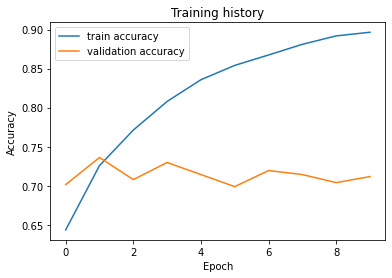

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
#plt.ylim([0, 1]);

In [ ]:
val_acc, _ = eval_model(
  model,
  val_data_loader,
  loss_fn,
  device,
  len(val) #Change it to test when you have the test results
)
val_acc.item()

0.7117117117117117

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  sentence = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["label"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      sentence.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(labels)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return sentence, predictions, prediction_probs, real_values

In [ ]:

y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  val_data_loader
)

In [ ]:
class_name=['Not_offensive',
'not-Kannada',
'Offensive_Targeted_Insult_Individual',
'Offensive_Targeted_Insult_Group',          
'Offensive_Untargetede',                    
'Offensive_Targeted_Insult_Other']

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, y_pred, target_names=class_name,zero_division=0))

                                      precision    recall  f1-score   support

                       Not_offensive       0.78      0.82      0.80       426
                         not-Kannada       0.24      0.36      0.28        45
Offensive_Targeted_Insult_Individual       0.71      0.56      0.63        66
     Offensive_Targeted_Insult_Group       0.00      0.00      0.00        16
               Offensive_Untargetede       0.09      0.06      0.07        33
     Offensive_Targeted_Insult_Other       0.80      0.77      0.78       191

                            accuracy                           0.71       777
                           macro avg       0.44      0.43      0.43       777
                        weighted avg       0.70      0.71      0.70       777



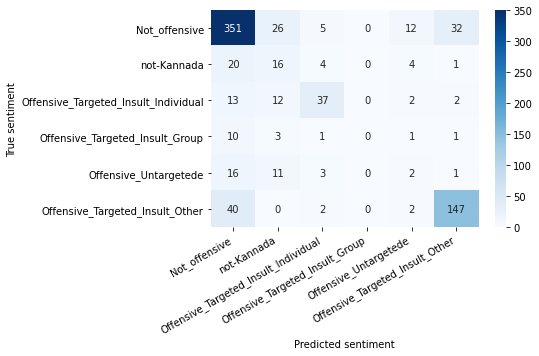

In [ ]:
import seaborn as sns
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_name, columns=class_name)
show_confusion_matrix(df_cm)